In [1]:
import video_embedding as ve

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
batch_size = 1

image_size = 216
duration = 30
clip_size = 90
num_workers = 1


video_list = ["example_video.mp4"]
print(len(video_list))

augmentator = ve.VideoAugmentator(duration=duration, crop_size=image_size, multiplier=6)
dataset = ve.VidioDataset(video_list, augmentator, clip_size, temporal_downsample=2)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

1


/home/dattalab/miniconda3/envs/video_embedding/lib/python3.10/site-packages/albumentations/core/validation.py:111: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [3]:
# import numpy as np
# x_one, x_two = next(iter(dataloader))
# x_one = ve.untransform_video(x_one)
# x_two = ve.untransform_video(x_two)
# ve.play_videos(np.concatenate([x_one[:4],x_two[:4]]), 2, 4)

In [4]:
from torchvision import models
model = models.video.s3d(weights=models.video.S3D_Weights.DEFAULT)
model.classifier = torch.nn.Identity()

In [5]:
import os
feature_size = 1024
epochs = 1500
steps_per_epoch = 500
checkpoint_dir = 'barlowtwins_X3D_on_crops_v10'
loss_log = os.path.join(checkpoint_dir, "log_loss.txt")

learner = ve.BarlowTwins(model, feature_size).to('cuda').train()
opt = torch.optim.Adam(learner.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, 'min')

# Create checkpoint directory if it doesn't exist
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
if not os.path.exists(loss_log):
    open(loss_log, "w").close()

In [6]:
import os
print(os.listdir(checkpoint_dir))


['log_loss.txt']


In [7]:
import os
checkpoint_path = f'{checkpoint_dir}/checkpoint_52.pth'

if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    learner.load_state_dict(checkpoint['learner_state_dict'])
    opt.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    print(f"Resumed training from epoch {checkpoint['epoch']}")
else:
    print("No checkpoint found. Starting training from scratch.")
    start_epoch = 0


No checkpoint found. Starting training from scratch.


In [8]:
opt = torch.optim.Adam(learner.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, 'min', threshold=0.1)

In [9]:
import tqdm

for epoch in range(start_epoch, epochs):
    running_loss = 0.0
    loader = iter(dataloader)
    with tqdm.trange(steps_per_epoch, unit="batch") as tepoch:
        tepoch.set_description(f"Epoch {epoch+1}/{epochs}")
        
        for i in tepoch:
            x_one, x_two = next(loader)
            loss = learner(x_one.to('cuda'), x_two.to('cuda'))
            opt.zero_grad()
            loss.backward()
            opt.step()

            running_loss += loss.item()
            tepoch.set_postfix(loss=running_loss / (i + 1))  # Display running loss

    avg_loss = running_loss / steps_per_epoch
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'learner_state_dict': learner.state_dict(),
        'optimizer_state_dict': opt.state_dict(),
        'loss': avg_loss,  # Save running loss
    }, f'{checkpoint_dir}/checkpoint_{epoch+1}.pth')
    open(loss_log, "a").write(f"{epoch}\t{avg_loss}\n")
    
    scheduler.step(avg_loss)

Epoch 1/1500:   0%|                                  | 0/500 [00:00<?, ?batch/s]/home/dattalab/miniconda3/envs/video_embedding/lib/python3.10/site-packages/albumentations/core/validation.py:111: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
Epoch 1/1500:   0%|                                  | 0/500 [00:01<?, ?batch/s]

[Projector] Input: torch.Size([1, 1024])
[Projector] After layer1: torch.Size([1, 1024])
[Projector] After layer2: torch.Size([1, 1024])
[Projector] After layer3 (output): torch.Size([1, 1024])
[Projector] Input: torch.Size([1, 1024])
[Projector] After layer1: torch.Size([1, 1024])
[Projector] After layer2: torch.Size([1, 1024])
[Projector] After layer3 (output): torch.Size([1, 1024])


ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 1024])

### inspect model 

In [ ]:




def forward(self, x):
    print("Projector input:", x.shape)
    for layer in self.layers:
        x = layer(x)
        print(" -> after", layer, ":", x.shape)
    return x


In [9]:
def get_clip(path, start, duration=60):
    reader = OpenCVReader(path)
    clip = reader[start:start+duration]
    return np.stack(clip)

In [13]:
video_paths = [f for f in glob.glob('../../data/*/*.cropped.mp4') if not 'down2' in f]
lengths = [len(OpenCVReader(p)) for p in video_paths]

# from custom_byol import BYOL
# from torchvision import models

# image_size = 216
# duration = 30

# #checkpoint = torch.load("siamsiam_S3D_on_crops_v4/checkpoint_138.pth")
# model = models.video.s3d(weights=models.video.S3D_Weights.DEFAULT)
# learner = BYOL(
#     model,
#     (3, duration, image_size, image_size),
#     hidden_layer='avgpool',
#     use_momentum=False
# ).to('cuda').eval()
# learner.load_state_dict(checkpoint['learner_state_dict'])


In [15]:
paths = []
starts = []
embeddings = []

for i in tqdm.trange(5000):
    ix = np.random.choice(len(video_paths))
    path = video_paths[ix]
    start = np.random.randint(lengths[ix]-60)
    clip = get_clip(path, start, duration=60)[::2]
    clip = center_crop(clip, image_size)
    X = transform_video(clip)[None]
    embedding = model(X.to("cuda"))
    embeddings.append(embedding.detach().cpu().numpy()[0])
    starts.append(start)
    paths.append(path)

import joblib
embeddings = np.array(embeddings)
joblib.dump((paths, starts, embeddings), 'tmp-v10.p')


100%|██████████| 5000/5000 [07:25<00:00, 11.23it/s]


['tmp-v10.p']

In [18]:
from umap import UMAP
from sklearn.decomposition import PCA

Xpca = PCA(n_components=20).fit_transform(embeddings)
xy = UMAP(n_components=2, n_neighbors=50).fit_transform(embeddings)

In [44]:
# xy_emb = xy
# Xpca_emp = Xpca

In [19]:
from sklearn.cluster import KMeans

n_clusters = 8
clus = KMeans(n_clusters=n_clusters).fit_predict(Xpca)

/home/csw14/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [20]:
rois = ['A','B','C','D']
roi_ix = np.array([rois.index(f.split('.')[-3]) for f in paths])

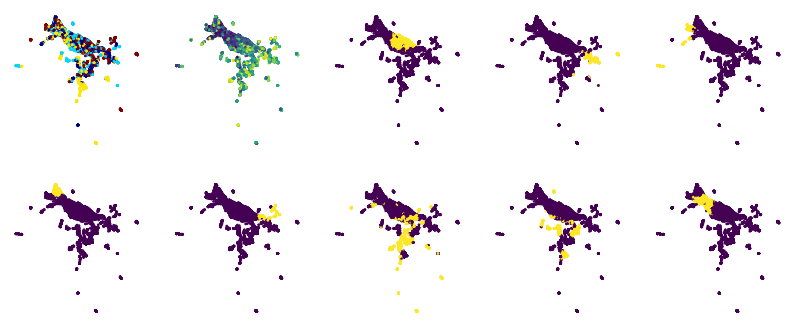

In [21]:
fig,axs = plt.subplots(2,int(np.ceil((n_clusters+2)/2)), sharey=True)
axs.flat[0].scatter(*xy.T,s=1,c=roi_ix, cmap=plt.cm.jet)
axs.flat[1].scatter(*xy.T,s=1,c=np.array(starts))
for i in range(n_clusters):
    axs.flat[i+2].scatter(*xy.T,s=1,c=clus==i)
for ax in axs.flat:
    ax.axis('off')
fig.set_size_inches((10,4))

In [22]:
n_examples_per_cluster = 4

clips = []
for i in range(n_clusters):
    ixs = np.random.choice((clus==i).nonzero()[0], n_examples_per_cluster, replace=False)
    for ii in ixs:
        clips.append(get_clip(paths[ii], starts[ii], duration=60)[::2])
play_videos(np.stack(clips), n_clusters, n_examples_per_cluster)

In [23]:
from sklearn.cluster import KMeans

n_clusters = 16
clus = KMeans(n_clusters=n_clusters).fit_predict(Xpca)

/home/csw14/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [27]:
o = np.argsort(np.argsort([np.array(starts)[clus==i].mean() for i in range(n_clusters)]))
clus = o[clus]

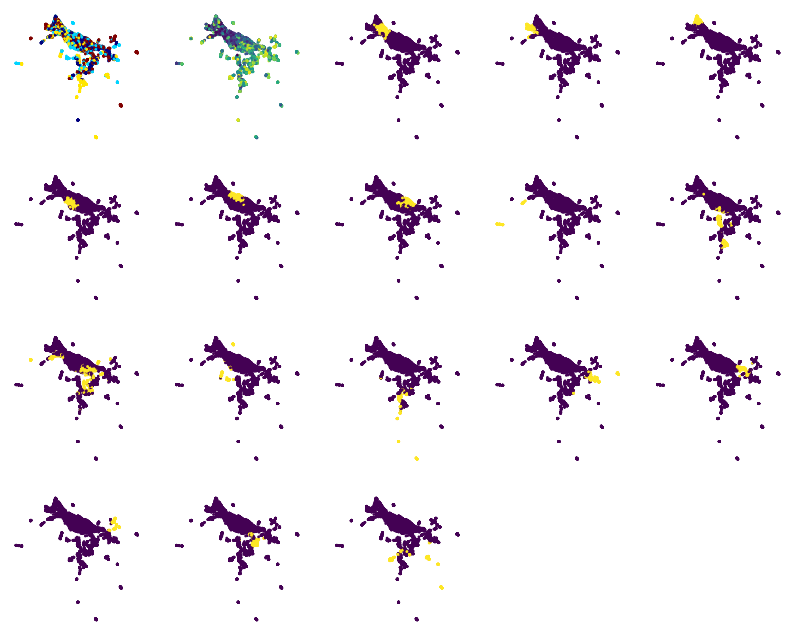

In [28]:
fig,axs = plt.subplots(4,int(np.ceil((n_clusters+2)/4)), sharey=True)
axs.flat[0].scatter(*xy.T,s=1,c=roi_ix, cmap=plt.cm.jet)
axs.flat[1].scatter(*xy.T,s=1,c=np.array(starts))
for i in range(n_clusters):
    axs.flat[i+2].scatter(*xy.T,s=1,c=clus==i)
for ax in axs.flat:
    ax.axis('off')
fig.set_size_inches((10,8))

In [29]:
n_examples_per_cluster = 4

clips = []
for i in range(n_clusters):
    ixs = np.random.choice((clus==i).nonzero()[0], n_examples_per_cluster, replace=False)
    for ii in ixs:
        clips.append(get_clip(paths[ii], starts[ii], duration=60)[::2])
play_videos(np.stack(clips), n_clusters, n_examples_per_cluster)

### run inference on video

In [34]:
import glob

exclude = [
    '24_9_16_fake_TRAP_pilot.rig2.A.cropped.mp4',
    '24_9_16_fake_TRAP_pilot.rig2.D.cropped.mp4',
    '24_9_18_fake_TRAP_pilot.rig2.A.cropped.mp4',
]
video_list = [f for f in glob.glob('../../cropped_videos/*') if f.split('/')[-1] not in exclude]

cmd = 'sbatch -p gpu_quad -t 30:00 --mem 2GB --gres=gpu:1 -c 2 --wrap  """module load ffmpeg; module load gcc/9.2.0; module load cuda/11.7; python apply_barlowtwins_X3D_on_crops-v10.py {}"""'
for video in video_list:
    print(cmd.format(video))


sbatch -p gpu_quad -t 30:00 --mem 2GB --gres=gpu:1 -c 2 --wrap  """module load ffmpeg; module load gcc/9.2.0; module load cuda/11.7; python apply_barlowtwins_X3D_on_crops-v10.py ../../cropped_videos/24_9_10_fake_TRAP_pilot.rig2.A.cropped.mp4"""
sbatch -p gpu_quad -t 30:00 --mem 2GB --gres=gpu:1 -c 2 --wrap  """module load ffmpeg; module load gcc/9.2.0; module load cuda/11.7; python apply_barlowtwins_X3D_on_crops-v10.py ../../cropped_videos/24_9_10_fake_TRAP_pilot.rig2.B.cropped.mp4"""
sbatch -p gpu_quad -t 30:00 --mem 2GB --gres=gpu:1 -c 2 --wrap  """module load ffmpeg; module load gcc/9.2.0; module load cuda/11.7; python apply_barlowtwins_X3D_on_crops-v10.py ../../cropped_videos/24_9_10_fake_TRAP_pilot.rig2.C.cropped.mp4"""
sbatch -p gpu_quad -t 30:00 --mem 2GB --gres=gpu:1 -c 2 --wrap  """module load ffmpeg; module load gcc/9.2.0; module load cuda/11.7; python apply_barlowtwins_X3D_on_crops-v10.py ../../cropped_videos/24_9_10_fake_TRAP_pilot.rig2.D.cropped.mp4"""
sbatch -p gpu_quad -

### run inference on clips chosen for annotation (across epochs)

In [8]:
from torchvision import models

model = models.video.s3d(weights=models.video.S3D_Weights.DEFAULT)
model.classifier = torch.nn.Identity()
model = model.to("cuda").eval()

image_size = 216
feature_size = 1024
checkpoint_dir = 'barlowtwins_X3D_on_crops_v10'
loss_log = os.path.join(checkpoint_dir, "log_loss.txt")

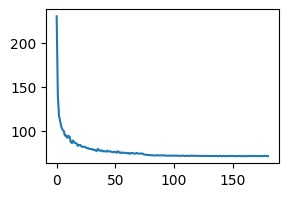

In [5]:
plt.plot(np.loadtxt(loss_log, delimiter="\t")[:,1])
plt.gcf().set_size_inches((3,2))

In [28]:
import json, h5py
annos_path = "../../annotations/24_10_2_cropped_2sec_v1.json"
annotations = json.load(open(annos_path,"r"))

In [ ]:
for epoch in [1, 10, 50, 150]:
    checkpoint_path = f'{checkpoint_dir}/checkpoint_{epoch}.pth'
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])

    save_path = annos_path.replace(".json", f".embeddings.epoch{epoch}.h5")
    with h5py.File(save_path, "w") as h5:
        embeddings = h5.create_dataset("embeddings", (len(annotations), feature_size))
        for i in tqdm.trange(len(annotations)):
            path, start, end, _ = annotations[i]
            clip = np.stack(OpenCVReader("../../"+path)[start:end][::2])
            clip = center_crop(clip, image_size)
            X = transform_video(clip)[None]
            embedding = model(X.to("cuda")).detach().cpu().numpy()[0]
            embeddings[i] = embedding

/tmp/ipykernel_266059/4193309314.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)
 27%|██▋       | 1368/5000 [04:10<10:43,  5.65i

### visualize results

In [1]:
import h5py
from umap import UMAP
from sklearn.decomposition import PCA

annos_path = "../../annotations/24_10_2_cropped_2sec_v1.json"

all_Xpca = []
all_umap = []
for epoch in [1, 10, 50, 150]:
    print(epoch)
    save_path = annos_path.replace(".json", f".embeddings.epoch{epoch}.h5")
    with h5py.File(save_path, 'r') as h5:
        embeddings = h5["embeddings"][()]
        Xpca = PCA(n_components=20).fit_transform(embeddings)
        xy = UMAP(n_components=2, n_neighbors=50).fit_transform(embeddings) 
        all_Xpca.append(Xpca)
        all_umap.append(xy)

/home/csw14/miniconda3/envs/torch/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1
10
50
150


In [5]:
import numpy as np
import json
import matplotlib.pyplot as plt

annotations = json.load(open(annos_path, "r"))
starts = np.array([start for (path, start, end, labels) in annotations])
all_labels = sorted(set(sum([labels for (path, start, end, labels) in annotations], [])))
has_label = np.array([[l in labels for _,_,_,labels in annotations] for l in all_labels])
use_labels_ix = (has_label.sum(1) >= 10).nonzero()[0]

rois = ['A','B','C','D']
paths = [path for (path, start, end, labels) in annotations]
roi_ix = np.array([rois.index(f.split('.')[-3]) for f in paths])

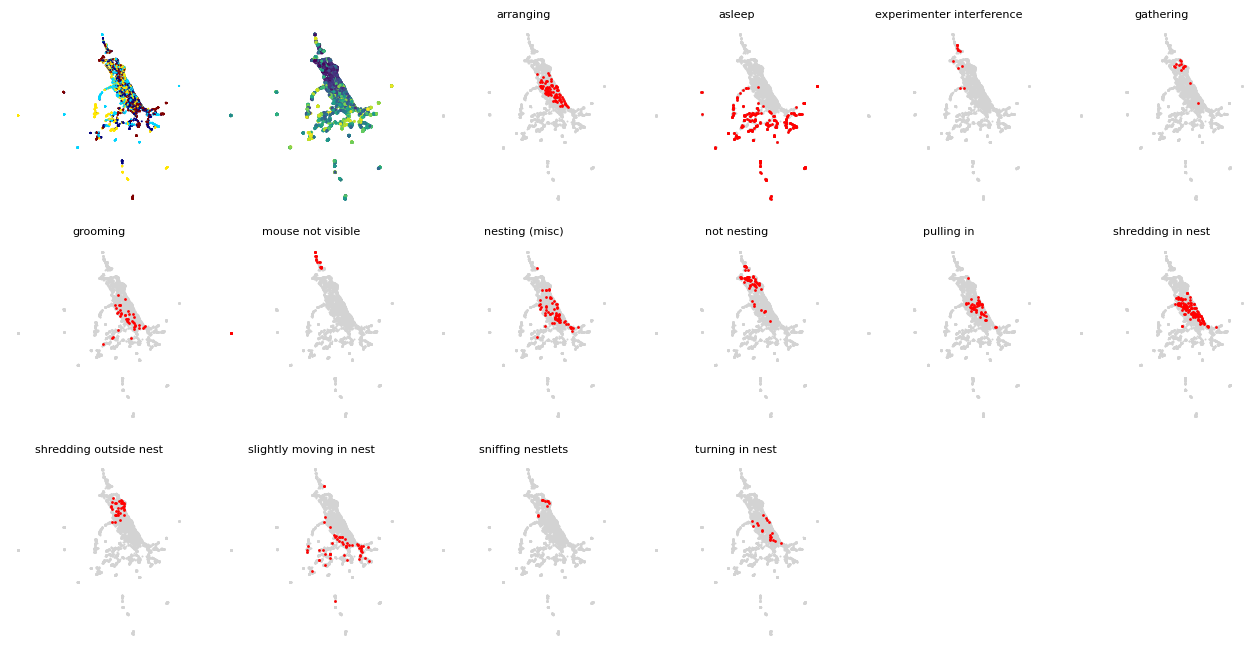

In [21]:
xy = all_umap[-1]
num_plots = len(use_labels_ix) + 2
num_cols = 6
fig,axs = plt.subplots(int(np.ceil(num_plots / num_cols)), num_cols)
axs.flat[0].scatter(*xy.T, c=roi_ix, cmap=plt.cm.jet, s=2, linewidth=0)
axs.flat[1].scatter(*xy.T, c=starts, s=5, linewidth=0)
for ax,i in zip(axs.flat[2:], use_labels_ix):
    ax.scatter(*xy.T, c='lightgray', s=2, linewidth=0)
    ax.scatter(*xy[has_label[i]].T, c='r', s=4, linewidth=0)
    ax.set_title(all_labels[i], fontsize=8)
for ax in axs.flat:
    ax.axis("off")
fig.set_size_inches((16, 16/axs.shape[1]*axs.shape[0]))

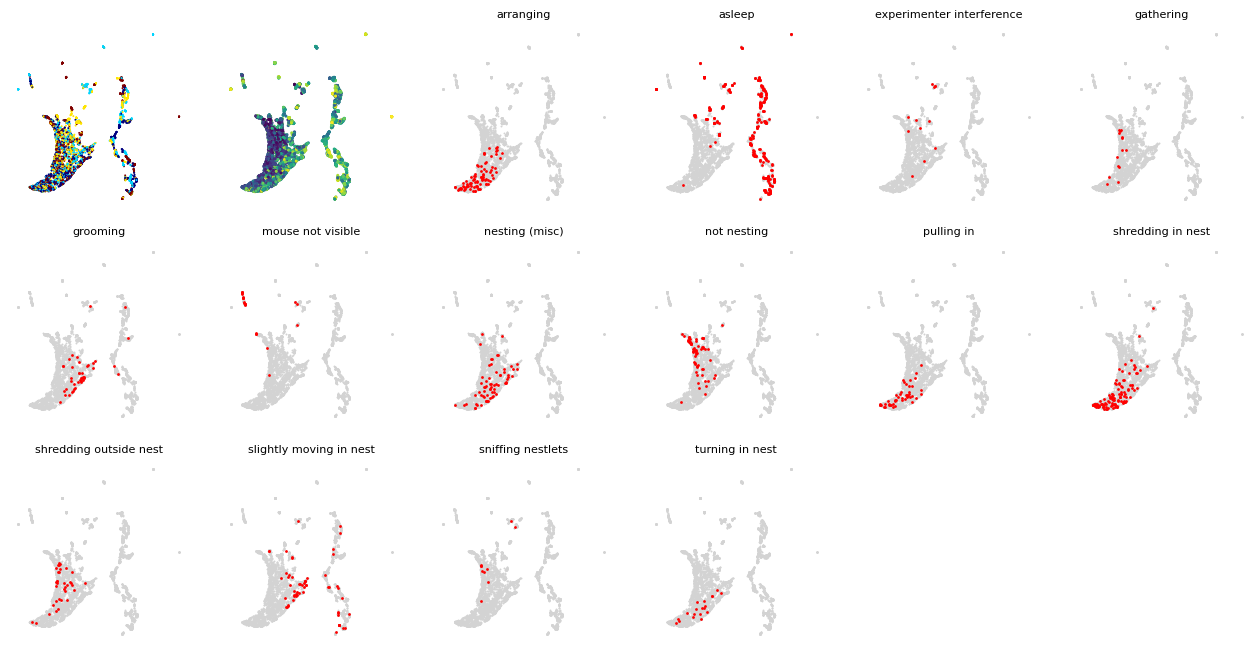

In [22]:
xy = all_umap[0]
num_plots = len(use_labels_ix) + 2
num_cols = 6
fig,axs = plt.subplots(int(np.ceil(num_plots / num_cols)), num_cols)
axs.flat[0].scatter(*xy.T, c=roi_ix, cmap=plt.cm.jet, s=2, linewidth=0)
axs.flat[1].scatter(*xy.T, c=starts, s=5, linewidth=0)
for ax,i in zip(axs.flat[2:], use_labels_ix):
    ax.scatter(*xy.T, c='lightgray', s=2, linewidth=0)
    ax.scatter(*xy[has_label[i]].T, c='r', s=4, linewidth=0)
    ax.set_title(all_labels[i], fontsize=8)
for ax in axs.flat:
    ax.axis("off")
fig.set_size_inches((16, 16/axs.shape[1]*axs.shape[0]))